# Assignment 1

This section will make you familier with
1. some pytorch basics
2. how to train a simple model with linear layers and non-linearity activation layer
3. the effect of number of layers and non-linearity activation

In [1]:
# Import dependencies
import random
import numpy as np
import torch
import torch.nn as nn

from matplotlib import pyplot as plt
from matplotlib.pyplot import plot, title, axis

In [2]:
# Set up your device
cuda = torch.cuda.is_available()
device = torch.device("cuda:0" if cuda else "cpu")

In [3]:
# Set up random seed to 1008. Do not change the random seed.
# Yes, these are all necessary when you run experiments!
seed = 1008
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)
if cuda:
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.benchmark = False
    torch.backends.cudnn.deterministic = True

# 1. Tensor [2 pt]

1.1. Write a function `build_tensor_1()` that returns the 2D tensor with integers below. **Do not use any loops**. [1 pt]

```
0, 0, 0, 0, 0, 0, 0, 0, 0, 0
0, 1, 1, 1, 0, 0, 2, 2, 2, 0
0, 1, 1, 1, 0, 0, 2, 2, 2, 0
0, 1, 1, 1, 0, 0, 2, 2, 2, 0
0, 0, 0, 0, 0, 0, 0, 0, 0, 0
0, 0, 0, 0, 0, 0, 0, 0, 0, 0
0, 3, 3, 3, 0, 0, 4, 4, 4, 0
0, 3, 3, 3, 0, 0, 4, 4, 4, 0
0, 3, 3, 3, 0, 0, 4, 4, 4, 0
0, 0, 0, 0, 0, 0, 0, 0, 0, 0
```

Hint: Use the slicing operator.

In [4]:
def build_tensor_1():
    # TODO
    tensor_1 = torch.zeros((10, 10))
    tensor_1[1:4, 1:4] = 1
    tensor_1[1:4, 6:9] = 2
    tensor_1[6:9, 1:4] = 3
    tensor_1[6:9, 6:9] = 4
    return tensor_1

In [5]:
# You can use this assertion to make sure the answer is right.
# Before diving into the next question, you should pass the test.
assert (build_tensor_1() ==
        torch.tensor([[0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 1, 1, 1, 0, 0, 2, 2, 2, 0],
        [0, 1, 1, 1, 0, 0, 2, 2, 2, 0],
        [0, 1, 1, 1, 0, 0, 2, 2, 2, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 3, 3, 3, 0, 0, 4, 4, 4, 0],
        [0, 3, 3, 3, 0, 0, 4, 4, 4, 0],
        [0, 3, 3, 3, 0, 0, 4, 4, 4, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0]])).all()

1.2. Use the [broadcasting semantics](https://pytorch.org/docs/stable/notes/broadcasting.html) to write a function `build_tensor_2()` that returns the 2D tensor with integers below. **Do not use any loops**. [1 pts]

```
0,  1,  2,  3,  4,  5,  6,  7,  8,  9
1,  2,  3,  4,  5,  6,  7,  8,  9, 10
2,  3,  4,  5,  6,  7,  8,  9, 10, 11
3,  4,  5,  6,  7,  8,  9, 10, 11, 12
4,  5,  6,  7,  8,  9, 10, 11, 12, 13
5,  6,  7,  8,  9, 10, 11, 12, 13, 14
6,  7,  8,  9, 10, 11, 12, 13, 14, 15
7,  8,  9, 10, 11, 12, 13, 14, 15, 16
8,  9, 10, 11, 12, 13, 14, 15, 16, 17
9, 10, 11, 12, 13, 14, 15, 16, 17, 18
```

In [6]:
def build_tensor_2():
    # TODO
    tensor_2 = torch.arange(10).unsqueeze(-1)
    return tensor_2 + tensor_2.T

In [7]:
# You can use this assertion to make sure the answer is right.
# Before diving into the next question, you should pass the test.
assert (build_tensor_2() ==
        torch.tensor([[ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9],
        [ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10],
        [ 2,  3,  4,  5,  6,  7,  8,  9, 10, 11],
        [ 3,  4,  5,  6,  7,  8,  9, 10, 11, 12],
        [ 4,  5,  6,  7,  8,  9, 10, 11, 12, 13],
        [ 5,  6,  7,  8,  9, 10, 11, 12, 13, 14],
        [ 6,  7,  8,  9, 10, 11, 12, 13, 14, 15],
        [ 7,  8,  9, 10, 11, 12, 13, 14, 15, 16],
        [ 8,  9, 10, 11, 12, 13, 14, 15, 16, 17],
        [ 9, 10, 11, 12, 13, 14, 15, 16, 17, 18]])).all()

# 2. Non-linear regression [8 pts]

In this section, we will explore and get comfortable initializing modules like nn.Linear and using non-linearities in PyTorch.

We will separately train a single-layer neural network without nonlinear activation, a multi-layer neural network without nonlinear activation, a single-layer neural network with nonlinear activation, and a multi-layer neural network with nonlinear activation to fit the same nonlinear target function $f(x)$:

$$
f(x) = x^3 - x^2 + 25\sin(2x)
$$.

## 2.1 Generate training data [1 pt]
The training data consists of 100 pairs of
 values. Each pair is generated by first sampling an
 value from a uniform distribution. For each sampled
, we compute the value of the target function
 and add Gaussian noise to it.

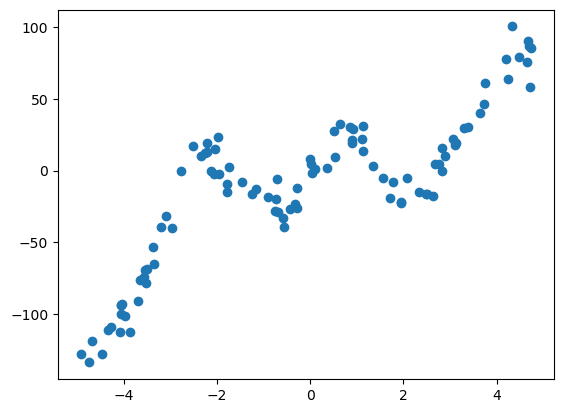

In [8]:
nObs = 100 # number of observations

# get noise sampled from standard normal distribution
yNoise = torch.randn(100)

# get observations
xObs = 10 * torch.rand([nObs]) - 5    # uniform from [-5,5]
yObs = yNoise * 10 + xObs ** 3 - xObs ** 2 + 25 * torch.sin(2 * xObs)

# plot the data
plt.scatter(xObs, yObs)
plt.show()

## 2.2 Define the neural networks [3 pts]

PyTorch defines a special-purpose class called `nn.Module` from which pre-defined neural networks or custom-made networks inherit the structure and basic functionality. Below, we define our feed-forward neural network as a class extending `nn.Module`. Minimally, we have to define two functions for this to work:

- the **initialization** function `_init__` which defines which variables (mostly, but not exclusively: parameters) our model has (using `nn.Linear` instantiates a linear layer with all the trainable parameters (weights and biases) implicitly);

- the **forward** pass which takes the model's input and computes the corresponding prediction given the current parameter values.

Here is a neural network with three hidden layers of size 10 and ReLU non-linearity:

In [9]:
# Define a Linear Classifier with three hidden layers of size 10 and ReLU non-linearity
class Linear_3H_explicit(nn.Module):
    def __init__(self):
        super().__init__()
        self.nInput = 1
        self.nHidden = 10
        self.nOutput = 1
        self.linear1 = nn.Linear(self.nInput, self.nHidden)
        self.linear2 = nn.Linear(self.nHidden, self.nHidden)
        self.linear3 = nn.Linear(self.nHidden, self.nHidden)
        self.ReLU    = nn.ReLU()
        self.classifier = nn.Linear(self.nHidden, self.nOutput)

    def forward(self, x):
        h1 = self.ReLU(self.linear1(x))
        h2 = self.ReLU(self.linear2(h1))
        h3 = self.ReLU(self.linear3(h2))
        return self.classifier(h3)

Here is another, more condensed definition of the same model, which uses the `nn.Sequantial` function to neatly chain components, thus defining the model parameters and the forward pass in one swoop.

In [10]:
# Define a Linear Classifier with three hidden layers of size 10 and ReLU non-linearity
class Linear_3H_condensed(nn.Module):
    def __init__(self):
        super().__init__()
        self.nInput = 1
        self.nHidden = 10
        self.nOutput = 1
        self.classifier = nn.Sequential(
            nn.Linear(self.nInput, self.nHidden),
            nn.ReLU(),
            nn.Linear(self.nHidden, self.nHidden),
            nn.ReLU(),
            nn.Linear(self.nHidden, self.nHidden),
            nn.ReLU(),
            nn.Linear(self.nHidden, self.nOutput)
        )

    def forward(self, x):
        return self.classifier(x)

Next, try defining different neural networks according to the requirements in the way you prefer.

In [11]:
# Define a Linear Classifier with a single linear layer and no non-linearity (no activation function)
# (no hidden layer)
class Linear_0H_wo_act(nn.Module):
    def __init__(self):
        super().__init__()

        # TODO
        self.nInput = 1
        self.nOutput = 1
        self.classifier = nn.Linear(self.nInput, self.nOutput)

    def forward(self, x):
        # TODO
        return self.classifier(x)

In [12]:
# Define a Linear Classifier with three hidden layers of size 10 and no non-linearity (no activation function)
class Linear_3H_wo_act(nn.Module):
    def __init__(self):
        super().__init__()

        # TODO
        self.nInput = 1
        self.nHidden = 10
        self.nOutput = 1
        self.classifier = nn.Sequential(
            nn.Linear(self.nInput, self.nHidden),
            nn.Linear(self.nHidden, self.nHidden),
            nn.Linear(self.nHidden, self.nHidden),
            nn.Linear(self.nHidden, self.nOutput)
        )

    def forward(self, x):
        # TODO
        return self.classifier(x)

In [13]:
# Define a Linear Classifier with a single hidden layers of size 10 and ReLU non-linearity
class Linear_1H(nn.Module):
    def __init__(self):
        super().__init__()

        # TODO
        self.nInput = 1
        self.nHidden = 10
        self.nOutput = 1
        self.classifier = nn.Sequential(
            nn.Linear(self.nInput, self.nHidden),
            nn.ReLU(),
            nn.Linear(self.nHidden, self.nOutput)
        )

    def forward(self, x):
        # TODO
        return self.classifier(x)

## 2.3 Train the model (3 pts)

We can now train the model with the training data. You can look at some [example pytorch tutorials](https://pytorch.org/tutorials/beginner/introyt/trainingyt.html) to learn how to:
- initialize optimizers
- zero gradient
- backprop the loss
- step the gradient

Note: This is full batch. We compute forward on whole x, y.
No need for dataloaders nor loop over batches.
Just pass all of x to model's forward pass.

In [14]:
def train(model, x, y):
    # Define the MSE loss function and Adam optimizer with learning rate 0.001
    loss_function = torch.nn.MSELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

    nTrainSteps = 20000

    # Send model and data to device
    model = model.to(device)
    x = x.to(device)
    y = y.to(device)

    # Run the training loop
    for epoch in range(0, nTrainSteps):
        # Set current loss value
        current_loss = 0.0

        # TODO: Zero the gradients
        optimizer.zero_grad()


        # Perform forward pass (make sure to supply the input in the right way)
        outputs = model(x.unsqueeze(-1))

        # Compute loss
        loss = loss_function(outputs, y.unsqueeze(-1))

        # TODO: Perform backward pass
        loss.backward()

        # TODO: Perform optimization
        optimizer.step()

        # Print statistics
        current_loss += loss.item()

        if (epoch + 1) % 2500 == 0:
            print('Loss after epoch %5d: %.3f' %
                    (epoch + 1, current_loss))
            current_loss = 0.0

    # Process is complete.
    print('Training process has finished.')

    return outputs.detach().cpu()

The code below is to visualize the prediction. You may get different curves by running multiple times because of random initialization.

Loss after epoch  2500: 2549.401
Loss after epoch  5000: 2020.053
Loss after epoch  7500: 1602.138
Loss after epoch 10000: 1289.081
Loss after epoch 12500: 1074.429
Loss after epoch 15000: 946.252
Loss after epoch 17500: 889.014
Loss after epoch 20000: 877.991
Training process has finished.


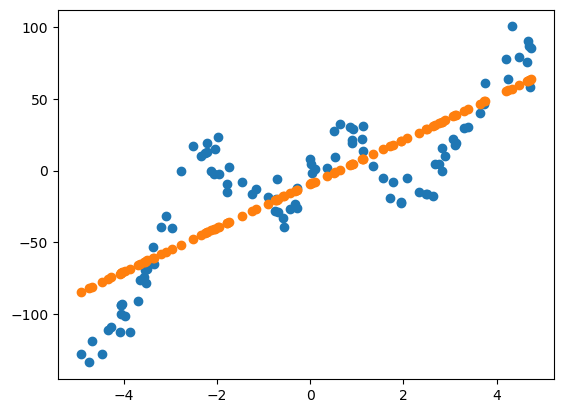

In [15]:
# A single linear layer and no non-linearity
model = Linear_0H_wo_act()
y_pred = train(model, x=xObs, y=yObs)

# Plot predictions vs actual data
plt.scatter(xObs, yObs)
plt.scatter(xObs, y_pred)
plt.show()

Loss after epoch  2500: 877.835
Loss after epoch  5000: 877.835
Loss after epoch  7500: 877.835
Loss after epoch 10000: 877.835
Loss after epoch 12500: 877.835
Loss after epoch 15000: 877.835
Loss after epoch 17500: 877.835
Loss after epoch 20000: 877.835
Training process has finished.


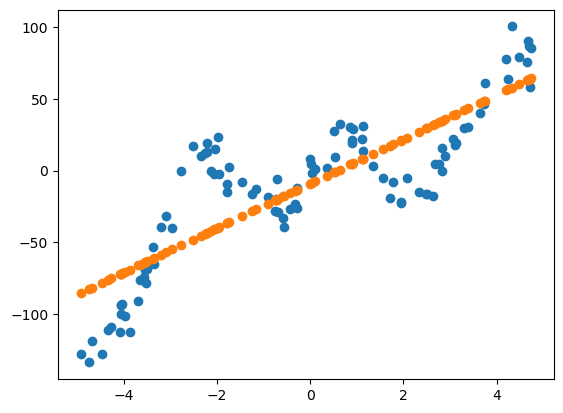

In [16]:
# Three hidden layers and no non-linearity
model = Linear_3H_wo_act()
y_pred = train(model, x=xObs, y=yObs)

# Plot predictions vs actual data
plt.scatter(xObs, yObs)
plt.scatter(xObs, y_pred)
plt.show()

Loss after epoch  2500: 836.902
Loss after epoch  5000: 650.539
Loss after epoch  7500: 291.871
Loss after epoch 10000: 240.812
Loss after epoch 12500: 240.035
Loss after epoch 15000: 240.035
Loss after epoch 17500: 240.035
Loss after epoch 20000: 240.035
Training process has finished.


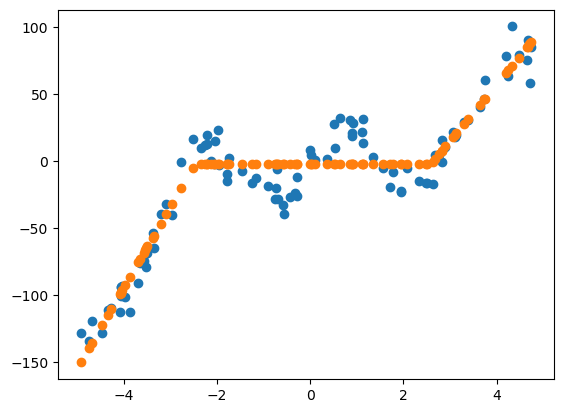

In [17]:
# A single hidden layers and ReLU non-linearity
model = Linear_1H()
y_pred = train(model, x=xObs, y=yObs)

# Plot predictions vs actual data
plt.scatter(xObs, yObs)
plt.scatter(xObs, y_pred)
plt.show()

Loss after epoch  2500: 167.227
Loss after epoch  5000: 70.926
Loss after epoch  7500: 64.506
Loss after epoch 10000: 62.496
Loss after epoch 12500: 61.328
Loss after epoch 15000: 60.523
Loss after epoch 17500: 59.423
Loss after epoch 20000: 56.945
Training process has finished.


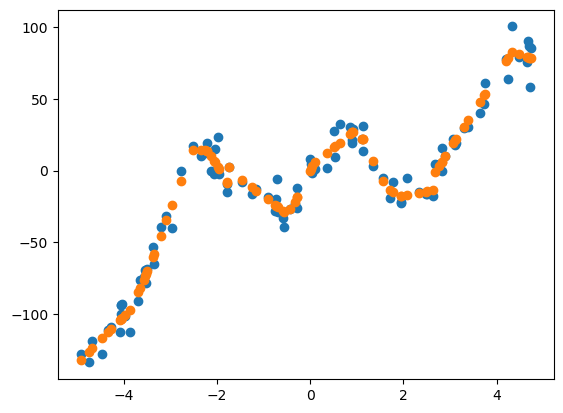

In [18]:
# Three hidden layers and ReLU non-linearity
model = Linear_3H_condensed()
y_pred = train(model, x=xObs, y=yObs)

# Plot predictions vs actual data
plt.scatter(xObs, yObs)
plt.scatter(xObs, y_pred)
plt.show()

## 2.4 Discussions [1 pt]

Based on the above experimental results, please discuss the effect of the nonlinear activation function and the number of hidden layers.

- nonlinear activation function能加强模型的拟合能力
    - 线性层不论叠加多少层，仍然等价于只有一个线性层
    - 添加非线性层给了模型拟合更复杂函数的机会
- 随着hidden layers增大，模型(w/o activation)的拟合能力几乎不变，特别是此处数据量很少、待拟合函数较简单的情况下，经过训练后都拟合到由最小二乘法计算出的直线上
- 随着hidden layers增大，模型(w/ activation)的拟合能力增强
    - 一方面，模型参数增加使得表达能力增加
    - 另一方面，非线性函数的复合也会导致模型能够表征或逼近的函数的复杂程度增加